<div style="font-size:40px; color:#0F2080;">
  Imports
</div>

In [1]:
# ========== Standard Library ==========
import os
import json
import warnings
from pathlib import Path
import glob

# ========== Scientific Python Stack ==========
import numpy as np
from numpy.polynomial import Polynomial
import scipy
from tqdm import tqdm

# ========== Plotting ==========
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import colormaps, cm

# ========== Astropy ==========
from astropy.io import fits
from astropy.table import Table, Column
from astropy.visualization import simple_norm
from astropy.convolution import convolve, Gaussian2DKernel
from astropy import units as u

# ========== JWST Pipeline ==========
from jwst.combine_1d import Combine1dStep
from jwst.datamodels import SpecModel, MultiSpecModel

# ========== specutils ==========
from specutils import Spectrum1D, SpectralRegion
from specutils.manipulation import extract_region

# ========== photutils ==========
from photutils.aperture import aperture_photometry, CircularAnnulus

# Directories
repo_dir = Path().resolve().parent
polycyclic_dir = repo_dir / "1_Polycyclic"
aromatic_dir   = repo_dir / "2_Aromatic"
hydrocarbons_dir = repo_dir / "3_Hydrocarbons"

fits_files = sorted(hydrocarbons_dir.glob("*.fits"))

print(f"Found {len(fits_files)} FITS files in {hydrocarbons_dir}:")
for file in fits_files:
    print(file.name)

Found 56 FITS files in C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons:
CH1_ring1.fits
CH1_ring2.fits
CH1_ring3.fits
CH1_ring4.fits
CH1_ring5.fits
CH1_ring6.fits
CH1_ring7.fits
CH1_ring8.fits
CH2_ring1.fits
CH2_ring2.fits
CH2_ring3.fits
CH2_ring4.fits
CH2_ring5.fits
CH2_ring6.fits
CH2_ring7.fits
CH2_ring8.fits
CH3_ring1.fits
CH3_ring2.fits
CH3_ring3.fits
CH3_ring4.fits
CH3_ring5.fits
CH3_ring6.fits
CH3_ring7.fits
CH3_ring8.fits
jw01328-c1006_t014_miri_ch1-shortmediumlong_s3d.fits
jw01328-c1006_t014_miri_ch1-shortmediumlong_x1d.fits
jw01328-c1006_t014_miri_ch2-shortmediumlong_s3d.fits
jw01328-c1006_t014_miri_ch2-shortmediumlong_x1d.fits
jw01328-c1006_t014_miri_ch3-shortmediumlong_s3d.fits
jw01328-c1006_t014_miri_ch3-shortmediumlong_x1d.fits
NGC7469__stitched.fits
Ring1_1dspec.fits
Ring1_simplified.fits
Ring1_stitched.fits
Ring2_1dspec.fits
Ring2_simplified.fits
Ring2_stitched.fits
Ring3_1dspec.fits
Ring3_simplified.fits
Ring3_stitched.fits
Ring4_1dspec.fits
Ring4_simplified.fits

<div style="font-size:40px; color:#0F2080;">
  <span style="color:#F5793A;">Spectra
</div>

[CH1] PSF matched to ~0.3"
[CH2] PSF matched to ~0.3"
[CENTER] x = 23.46, y = 21.84 (common center)


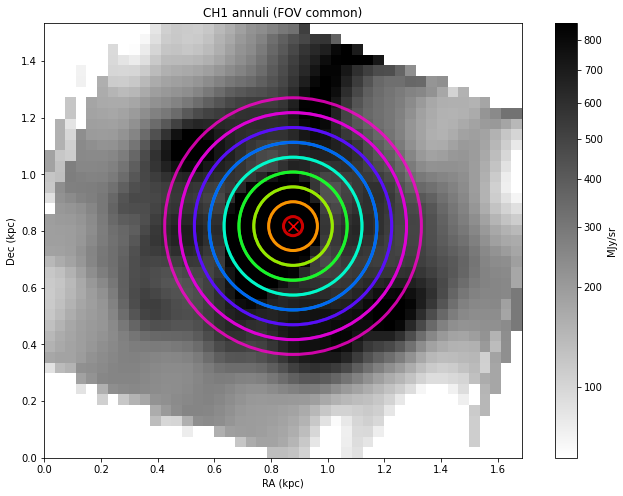

[MultiSpecModel] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\CH1_ring1.fits
[MultiSpecModel] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\CH1_ring2.fits
[MultiSpecModel] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\CH1_ring3.fits
[MultiSpecModel] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\CH1_ring4.fits
[MultiSpecModel] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\CH1_ring5.fits
[MultiSpecModel] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\CH1_ring6.fits
[MultiSpecModel] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\CH1_ring7.fits
[MultiSpecModel] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\CH1_ring8.fits


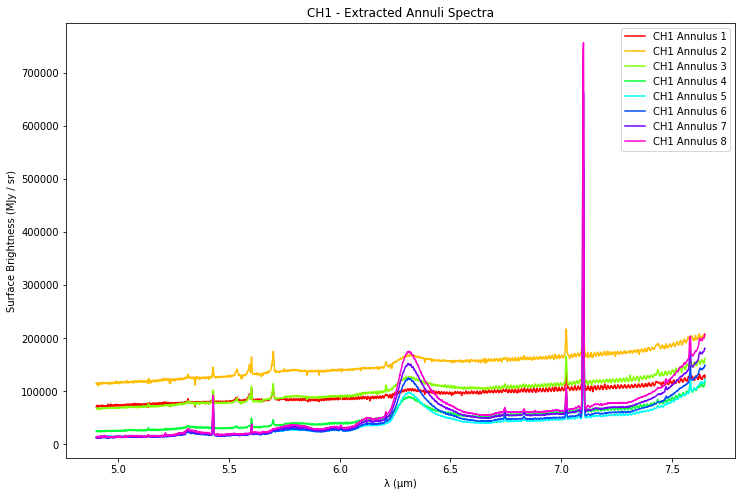

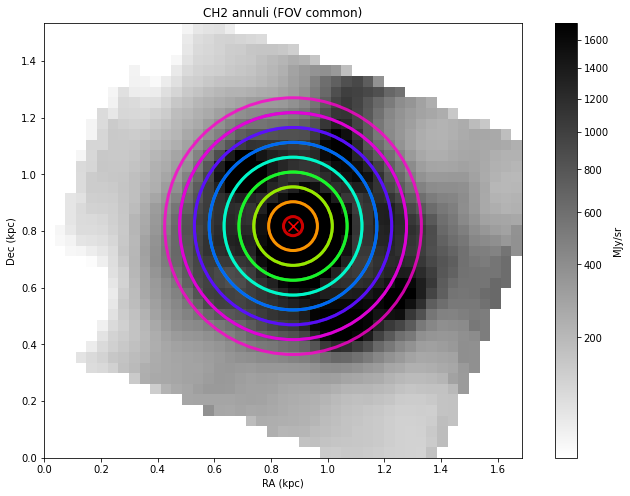

[MultiSpecModel] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\CH2_ring1.fits
[MultiSpecModel] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\CH2_ring2.fits
[MultiSpecModel] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\CH2_ring3.fits
[MultiSpecModel] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\CH2_ring4.fits
[MultiSpecModel] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\CH2_ring5.fits
[MultiSpecModel] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\CH2_ring6.fits
[MultiSpecModel] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\CH2_ring7.fits
[MultiSpecModel] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\CH2_ring8.fits


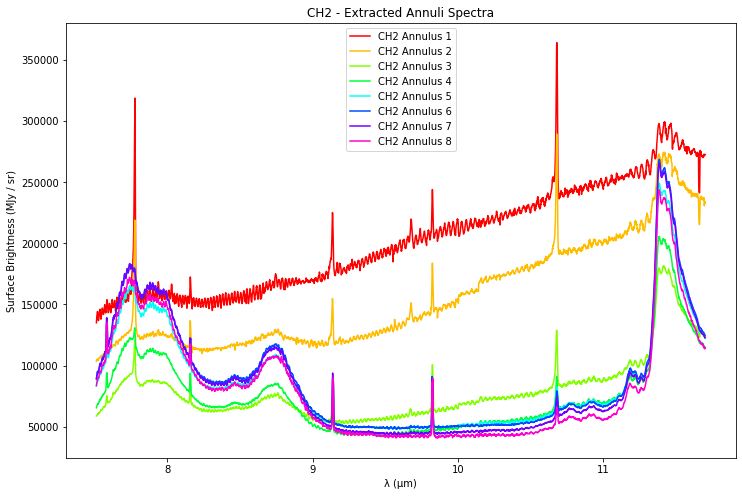

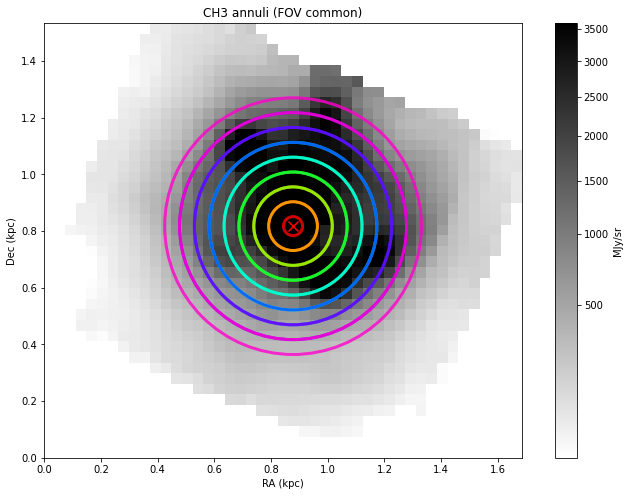

[MultiSpecModel] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\CH3_ring1.fits
[MultiSpecModel] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\CH3_ring2.fits
[MultiSpecModel] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\CH3_ring3.fits
[MultiSpecModel] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\CH3_ring4.fits
[MultiSpecModel] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\CH3_ring5.fits
[MultiSpecModel] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\CH3_ring6.fits
[MultiSpecModel] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\CH3_ring7.fits
[MultiSpecModel] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\CH3_ring8.fits


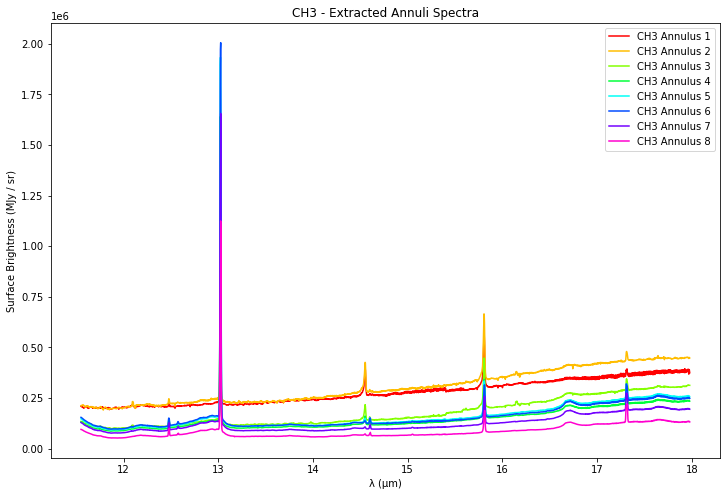

In [2]:
warnings.filterwarnings("ignore")
repo_dir = Path().resolve().parent
hydrocarbons_dir = repo_dir / "3_Hydrocarbons"

def save_ring_as_specmodel(filename, wavelengths, flux):
    n = len(wavelengths)
    spec_table = Table()
    spec_table['WAVELENGTH'] = Column(wavelengths, unit='um')
    spec_table['FLUX'] = Column(flux, unit='MJy/sr')
    spec_table['FLUX_ERROR'] = Column(np.ones(n)*0.1, unit='MJy/sr')
    spec_table['DQ'] = np.zeros(n, dtype=np.uint32)

    for col in ['FLUX_VAR_POISSON', 'FLUX_VAR_RNOISE', 'FLUX_VAR_FLAT',
                'SURF_BRIGHT', 'SB_ERROR', 'SB_VAR_POISSON', 
                'SB_VAR_RNOISE', 'SB_VAR_FLAT', 'BACKGROUND',
                'BKGD_ERROR', 'BKGD_VAR_POISSON', 'BKGD_VAR_RNOISE',
                'BKGD_VAR_FLAT', 'NPIXELS']:
        spec_table[col] = np.zeros(n)
    model = MultiSpecModel()
    model.spec = [{"spec_table": spec_table}]
    model.meta.instrument.name = 'MIRI'
    model.meta.exposure.type = 'MIR_MRS'
    model.meta.exposure.exposure_time = 1.0
    model.meta.bunit_data = 'MJy/sr'
    model.save(filename, overwrite=True)
    print(f"[MultiSpecModel] Saved: {filename}")

channels = {
    'CH1': hydrocarbons_dir / 'jw01328-c1006_t014_miri_ch1-shortmediumlong_s3d.fits',
    'CH2': hydrocarbons_dir / 'jw01328-c1006_t014_miri_ch2-shortmediumlong_s3d.fits',
    'CH3': hydrocarbons_dir / 'jw01328-c1006_t014_miri_ch3-shortmediumlong_s3d.fits',
}

pixel_scale_arcsec = 0.11
pixel_scale_pc = 37.41
pixel_scale_kpc = pixel_scale_pc / 1000
effective_fwhm = {'CH1': 0.22, 'CH2': 0.28, 'CH3': 0.66}
target_fwhm = 0.30
sigma_from_fwhm = lambda fwhm: fwhm / (2.0 * np.sqrt(2.0 * np.log(2)))
r0 = 0.9
step = 1.4
annuli_radii = [(r0 + i * step, r0 + (i+1) * step) for i in range(8)]


cubes = {}
collapsed_images = {}
min_shape = None

for ch, filename in channels.items():
    hdul = fits.open(filename)
    data = hdul[1].data.astype(np.float64)
    wl_start = hdul[1].header['CRVAL3']
    wl_step = hdul[1].header['CDELT3']
    wavelengths = wl_start + np.arange(data.shape[0]) * wl_step

    if effective_fwhm[ch] < target_fwhm:
        sigma_pix = np.sqrt(sigma_from_fwhm(target_fwhm)**2 - sigma_from_fwhm(effective_fwhm[ch])**2) / pixel_scale_arcsec
        data = np.array([convolve(slice, Gaussian2DKernel(sigma_pix), boundary='extend', nan_treatment='interpolate') for slice in data])
        print(f"[{ch}] PSF matched to ~{target_fwhm}\"")

    collapsed = np.nanmean(data, axis=0)
    collapsed_images[ch] = collapsed
    min_shape = collapsed.shape if min_shape is None else (
        min(min_shape[0], collapsed.shape[0]), min(min_shape[1], collapsed.shape[1])
    )
    cubes[ch] = (data, wavelengths)

for ch in collapsed_images:
    img = collapsed_images[ch]
    y_trim = (img.shape[0] - min_shape[0]) // 2
    x_trim = (img.shape[1] - min_shape[1]) // 2
    collapsed_images[ch] = img[y_trim:y_trim+min_shape[0], x_trim:x_trim+min_shape[1]]
    cubes[ch] = (cubes[ch][0][:, y_trim:y_trim+min_shape[0], x_trim:x_trim+min_shape[1]], cubes[ch][1])

combined_image = sum(img - np.nanmin(img) for img in collapsed_images.values())
mask = np.isfinite(combined_image)
total = np.nansum(combined_image[mask])
y_idx, x_idx = np.indices(combined_image.shape)
x_center = np.nansum(x_idx[mask] * combined_image[mask]) / total
y_center = np.nansum(y_idx[mask] * combined_image[mask]) / total
print(f"[CENTER] x = {x_center:.2f}, y = {y_center:.2f} (common center)")

cmap = colormaps.get_cmap('hsv')

for ch in channels:
    data, wavelengths = cubes[ch]
    collapsed = collapsed_images[ch]
    extent_x_kpc = collapsed.shape[1] * pixel_scale_kpc
    extent_y_kpc = collapsed.shape[0] * pixel_scale_kpc
    annuli_radii_kpc = [(r_in * pixel_scale_kpc, r_out * pixel_scale_kpc) for r_in, r_out in annuli_radii]

    plt.figure(figsize=(12, 8))
    norm = simple_norm(collapsed, 'sqrt', percent=88)
    plt.imshow(collapsed, origin='lower', cmap='binary', norm=norm,
               extent=[0, extent_x_kpc, 0, extent_y_kpc])
    plt.colorbar(label='MJy/sr')

    for i, (r_in, r_out) in enumerate(annuli_radii_kpc):
        ann = CircularAnnulus((x_center * pixel_scale_kpc, y_center * pixel_scale_kpc), r_in=r_in, r_out=r_out)
        ann.plot(color=cmap(i / len(annuli_radii)), lw=3, alpha=0.8)
    plt.scatter(x_center * pixel_scale_kpc, y_center * pixel_scale_kpc, color='red', s=100, marker='x')
    plt.xlabel('RA (kpc)')
    plt.ylabel('Dec (kpc)')
    plt.title(f'{ch} annuli (FOV common)')
    plt.show()

    plt.figure(figsize=(12, 8))
    for i, (r_in, r_out) in enumerate(annuli_radii):
        ann_ap = CircularAnnulus((x_center, y_center), r_in=r_in, r_out=r_out)
        flux = np.array([aperture_photometry(slice, ann_ap)['aperture_sum'][0] for slice in data])
        output_filename = hydrocarbons_dir / f"{ch}_ring{i+1}.fits"
        save_ring_as_specmodel(str(output_filename), wavelengths, flux)
        plt.plot(wavelengths, flux, label=f'{ch} Annulus {i+1}', color=cmap(i / len(annuli_radii)))
    plt.xlabel("λ (μm)")
    plt.ylabel("Surface Brightness (MJy / sr)")
    plt.title(f"{ch} - Extracted Annuli Spectra")
    plt.legend()
    plt.show()

<div style="font-size:40px; color:#0F2080;">
  <span style="color:#F5793A;">Enviorment</span>  <span style="color:#F5793A;"></span>
</div>

In [3]:
os.environ['CRDS_PATH'] = os.path.expanduser("~/crds_cache")
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

<div style="font-size:40px; color:#0F2080;">
   <span style="color:#F5793A;">Stitching</span>  <span style="color:#F5793A;"></span>
</div>

In [4]:
repo_dir = Path().resolve().parent
input_dir = repo_dir / "3_Hydrocarbons"
output_json_dir = repo_dir / "1_Polycyclic"
output_fits_dir = repo_dir / "3_Hydrocarbons"

output_json_dir.mkdir(exist_ok=True)
output_fits_dir.mkdir(exist_ok=True)

def create_association_file(output_name, input_files, filename):
    association = {
        "asn_type": "spec",
        "asn_rule": "combine1d",
        "asn_id": f"a{output_name}",
        "program": "12345",
        "target": "NGC7469",
        "asn_pool": "auto-gen",
        "version_id": "1.0",
        "products": [
            {
                "name": output_name,
                "members": [{"expname": file, "exptype": "science"} for file in input_files]
            }
        ]
    }
    with open(filename, "w") as json_file:
        json.dump(association, json_file, indent=4)
    print(f"[JSON] Created: {filename}")

channels = ['CH1', 'CH2', 'CH3']

for ring_number in range(1, 9):
    input_files = [str(input_dir / f"{ch}_ring{ring_number}.fits") for ch in channels]
    output_name = f"Ring{ring_number}"
    
    json_file = output_json_dir / f"{output_name}.json"
    stitched_file = output_fits_dir / f"{output_name}.fits"

    create_association_file(output_name, input_files, json_file)

    print(f"[Combine1dStep] Stitching: {input_files}")
    Combine1dStep.call(
        json_file,
        output_file=stitched_file,
        output_dir=str(output_fits_dir.as_posix()),
        suffix="stitched"
    )

[JSON] Created: C:\Users\Juan\Downloads\Research\JWSTPAH\1_Polycyclic\Ring1.json
[Combine1dStep] Stitching: ['C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\CH1_ring1.fits', 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\CH2_ring1.fits', 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\CH3_ring1.fits']


2025-05-19 00:19:19,659 - CRDS - INFO -  Calibration SW Found: jwst 1.13.4 (C:\Users\Juan\anaconda3\lib\site-packages\jwst-1.13.4.dist-info)
2025-05-19 00:19:20,354 - stpipe.Combine1dStep - INFO - Combine1dStep instance created.
2025-05-19 00:19:20,465 - stpipe.Combine1dStep - INFO - Step Combine1dStep running with args (WindowsPath('C:/Users/Juan/Downloads/Research/JWSTPAH/1_Polycyclic/Ring1.json'),).
2025-05-19 00:19:20,468 - stpipe.Combine1dStep - INFO - Step Combine1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\Ring1.fits', 'output_dir': 'C:/Users/Juan/Downloads/Research/JWSTPAH/3_Hydrocarbons', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'stitched', 'search_output_file': True, 'input_dir': '', 'exptime_key': 'exposure_time'}
2025-05-19 00:19:20,811 - stpipe.Combine1dStep - INFO - Using exposure time as the weight

[JSON] Created: C:\Users\Juan\Downloads\Research\JWSTPAH\1_Polycyclic\Ring2.json
[Combine1dStep] Stitching: ['C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\CH1_ring2.fits', 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\CH2_ring2.fits', 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\CH3_ring2.fits']


2025-05-19 00:19:21,631 - stpipe.Combine1dStep - INFO - Combine1dStep instance created.
2025-05-19 00:19:21,742 - stpipe.Combine1dStep - INFO - Step Combine1dStep running with args (WindowsPath('C:/Users/Juan/Downloads/Research/JWSTPAH/1_Polycyclic/Ring2.json'),).
2025-05-19 00:19:21,744 - stpipe.Combine1dStep - INFO - Step Combine1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\Ring2.fits', 'output_dir': 'C:/Users/Juan/Downloads/Research/JWSTPAH/3_Hydrocarbons', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'stitched', 'search_output_file': True, 'input_dir': '', 'exptime_key': 'exposure_time'}
2025-05-19 00:19:22,071 - stpipe.Combine1dStep - INFO - Using exposure time as the weight.
2025-05-19 00:19:22,073 - stpipe.Combine1dStep - WARNING - There is no WCS in the input.
2025-05-19 00:19:22,075 - stpipe.Combine1dStep - W

[JSON] Created: C:\Users\Juan\Downloads\Research\JWSTPAH\1_Polycyclic\Ring3.json
[Combine1dStep] Stitching: ['C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\CH1_ring3.fits', 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\CH2_ring3.fits', 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\CH3_ring3.fits']


2025-05-19 00:19:22,889 - stpipe.Combine1dStep - INFO - Combine1dStep instance created.
2025-05-19 00:19:23,003 - stpipe.Combine1dStep - INFO - Step Combine1dStep running with args (WindowsPath('C:/Users/Juan/Downloads/Research/JWSTPAH/1_Polycyclic/Ring3.json'),).
2025-05-19 00:19:23,005 - stpipe.Combine1dStep - INFO - Step Combine1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\Ring3.fits', 'output_dir': 'C:/Users/Juan/Downloads/Research/JWSTPAH/3_Hydrocarbons', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'stitched', 'search_output_file': True, 'input_dir': '', 'exptime_key': 'exposure_time'}
2025-05-19 00:19:23,333 - stpipe.Combine1dStep - INFO - Using exposure time as the weight.
2025-05-19 00:19:23,335 - stpipe.Combine1dStep - WARNING - There is no WCS in the input.
2025-05-19 00:19:23,337 - stpipe.Combine1dStep - W

[JSON] Created: C:\Users\Juan\Downloads\Research\JWSTPAH\1_Polycyclic\Ring4.json
[Combine1dStep] Stitching: ['C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\CH1_ring4.fits', 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\CH2_ring4.fits', 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\CH3_ring4.fits']


2025-05-19 00:19:24,145 - stpipe.Combine1dStep - INFO - Combine1dStep instance created.
2025-05-19 00:19:24,257 - stpipe.Combine1dStep - INFO - Step Combine1dStep running with args (WindowsPath('C:/Users/Juan/Downloads/Research/JWSTPAH/1_Polycyclic/Ring4.json'),).
2025-05-19 00:19:24,261 - stpipe.Combine1dStep - INFO - Step Combine1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\Ring4.fits', 'output_dir': 'C:/Users/Juan/Downloads/Research/JWSTPAH/3_Hydrocarbons', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'stitched', 'search_output_file': True, 'input_dir': '', 'exptime_key': 'exposure_time'}
2025-05-19 00:19:24,588 - stpipe.Combine1dStep - INFO - Using exposure time as the weight.
2025-05-19 00:19:24,590 - stpipe.Combine1dStep - WARNING - There is no WCS in the input.
2025-05-19 00:19:24,592 - stpipe.Combine1dStep - W

[JSON] Created: C:\Users\Juan\Downloads\Research\JWSTPAH\1_Polycyclic\Ring5.json
[Combine1dStep] Stitching: ['C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\CH1_ring5.fits', 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\CH2_ring5.fits', 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\CH3_ring5.fits']


2025-05-19 00:19:25,403 - stpipe.Combine1dStep - INFO - Combine1dStep instance created.
2025-05-19 00:19:25,521 - stpipe.Combine1dStep - INFO - Step Combine1dStep running with args (WindowsPath('C:/Users/Juan/Downloads/Research/JWSTPAH/1_Polycyclic/Ring5.json'),).
2025-05-19 00:19:25,523 - stpipe.Combine1dStep - INFO - Step Combine1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\Ring5.fits', 'output_dir': 'C:/Users/Juan/Downloads/Research/JWSTPAH/3_Hydrocarbons', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'stitched', 'search_output_file': True, 'input_dir': '', 'exptime_key': 'exposure_time'}
2025-05-19 00:19:25,860 - stpipe.Combine1dStep - INFO - Using exposure time as the weight.
2025-05-19 00:19:25,861 - stpipe.Combine1dStep - WARNING - There is no WCS in the input.
2025-05-19 00:19:25,863 - stpipe.Combine1dStep - W

[JSON] Created: C:\Users\Juan\Downloads\Research\JWSTPAH\1_Polycyclic\Ring6.json
[Combine1dStep] Stitching: ['C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\CH1_ring6.fits', 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\CH2_ring6.fits', 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\CH3_ring6.fits']


2025-05-19 00:19:26,686 - stpipe.Combine1dStep - INFO - Combine1dStep instance created.
2025-05-19 00:19:26,807 - stpipe.Combine1dStep - INFO - Step Combine1dStep running with args (WindowsPath('C:/Users/Juan/Downloads/Research/JWSTPAH/1_Polycyclic/Ring6.json'),).
2025-05-19 00:19:26,810 - stpipe.Combine1dStep - INFO - Step Combine1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\Ring6.fits', 'output_dir': 'C:/Users/Juan/Downloads/Research/JWSTPAH/3_Hydrocarbons', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'stitched', 'search_output_file': True, 'input_dir': '', 'exptime_key': 'exposure_time'}
2025-05-19 00:19:27,146 - stpipe.Combine1dStep - INFO - Using exposure time as the weight.
2025-05-19 00:19:27,148 - stpipe.Combine1dStep - WARNING - There is no WCS in the input.
2025-05-19 00:19:27,151 - stpipe.Combine1dStep - W

[JSON] Created: C:\Users\Juan\Downloads\Research\JWSTPAH\1_Polycyclic\Ring7.json
[Combine1dStep] Stitching: ['C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\CH1_ring7.fits', 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\CH2_ring7.fits', 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\CH3_ring7.fits']


2025-05-19 00:19:27,986 - stpipe.Combine1dStep - INFO - Combine1dStep instance created.
2025-05-19 00:19:28,104 - stpipe.Combine1dStep - INFO - Step Combine1dStep running with args (WindowsPath('C:/Users/Juan/Downloads/Research/JWSTPAH/1_Polycyclic/Ring7.json'),).
2025-05-19 00:19:28,106 - stpipe.Combine1dStep - INFO - Step Combine1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\Ring7.fits', 'output_dir': 'C:/Users/Juan/Downloads/Research/JWSTPAH/3_Hydrocarbons', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'stitched', 'search_output_file': True, 'input_dir': '', 'exptime_key': 'exposure_time'}
2025-05-19 00:19:28,457 - stpipe.Combine1dStep - INFO - Using exposure time as the weight.
2025-05-19 00:19:28,458 - stpipe.Combine1dStep - WARNING - There is no WCS in the input.
2025-05-19 00:19:28,461 - stpipe.Combine1dStep - W

[JSON] Created: C:\Users\Juan\Downloads\Research\JWSTPAH\1_Polycyclic\Ring8.json
[Combine1dStep] Stitching: ['C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\CH1_ring8.fits', 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\CH2_ring8.fits', 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\CH3_ring8.fits']


2025-05-19 00:19:29,287 - stpipe.Combine1dStep - INFO - Combine1dStep instance created.
2025-05-19 00:19:29,405 - stpipe.Combine1dStep - INFO - Step Combine1dStep running with args (WindowsPath('C:/Users/Juan/Downloads/Research/JWSTPAH/1_Polycyclic/Ring8.json'),).
2025-05-19 00:19:29,407 - stpipe.Combine1dStep - INFO - Step Combine1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\Ring8.fits', 'output_dir': 'C:/Users/Juan/Downloads/Research/JWSTPAH/3_Hydrocarbons', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'stitched', 'search_output_file': True, 'input_dir': '', 'exptime_key': 'exposure_time'}
2025-05-19 00:19:29,742 - stpipe.Combine1dStep - INFO - Using exposure time as the weight.
2025-05-19 00:19:29,744 - stpipe.Combine1dStep - WARNING - There is no WCS in the input.
2025-05-19 00:19:29,747 - stpipe.Combine1dStep - W

<div style="font-size:40px; color:#0F2080;">
   <span style="color:#F5793A;">Modify por PAHfit</span>  <span style="color:#F5793A;"></span>
</div>

In [5]:
repo_dir = Path().resolve().parent
hydrocarbons_dir = repo_dir / "3_Hydrocarbons"

for i in range(1, 9):
    stitched_file = hydrocarbons_dir / f"Ring{i}_stitched.fits"
    simplified_file = hydrocarbons_dir / f"Ring{i}_1dspec.fits"
    if not stitched_file.exists():
        print(f"[SKIP] Not found: {stitched_file.name}")
        continue
    model = MultiSpecModel(str(stitched_file))
    table = model.spec[0].spec_table

    wavelength = u.Quantity(table["WAVELENGTH"], unit=u.um)
    flux = u.Quantity(table["FLUX"], unit=u.MJy/u.sr)

    tab = Table()
    tab['wavelength'] = Column(wavelength, unit='um')
    tab['flux'] = Column(flux, unit='MJy/sr')
    tab.write(simplified_file, format='fits', overwrite=True)
    print(f"[PAHFIT-READY] Saved: {simplified_file.name}")

[PAHFIT-READY] Saved: Ring1_1dspec.fits
[PAHFIT-READY] Saved: Ring2_1dspec.fits
[PAHFIT-READY] Saved: Ring3_1dspec.fits
[PAHFIT-READY] Saved: Ring4_1dspec.fits
[PAHFIT-READY] Saved: Ring5_1dspec.fits
[PAHFIT-READY] Saved: Ring6_1dspec.fits
[PAHFIT-READY] Saved: Ring7_1dspec.fits
[PAHFIT-READY] Saved: Ring8_1dspec.fits


<div style="font-size:40px; color:#0F2080;">
   <span style="color:#F5793A;">Check everything is alright</span>  <span style="color:#F5793A;"></span>
</div>

In [6]:
r0 = 0.9
step = 1.4
num_rings = 13
pixel_scale_arcsec = 0.11
pixel_scale_pc = 37.41

print(f"{'Ring':>4} | {'R_in (px)':>8} | {'R_out (px)':>9} | {'R_out (arcsec)':>13} | {'R_out (pc)':>10}")
print('-'*56)
for i in range(num_rings):
    r_in = r0 + i * step
    r_out = r0 + (i+1) * step
    r_out_arcsec = r_out * pixel_scale_arcsec
    r_out_pc = r_out * pixel_scale_pc
    print(f"{i+1:4d} | {r_in:8.2f} | {r_out:9.2f} | {r_out_arcsec:13.2f} | {r_out_pc:10.2f}")

r_outer = r0 + num_rings * step
diameter_arcsec = 2 * r_outer * pixel_scale_arcsec
diameter_pc = 2 * r_outer * pixel_scale_pc
print(f"\nOutermost ring radius: {r_outer:.2f} px")
print(f"Diameter: {2*r_outer:.2f} px")
print(f"Diameter: {diameter_arcsec:.2f} arcsec")
print(f"Diameter: {diameter_pc:.2f} parsecs")

Ring | R_in (px) | R_out (px) | R_out (arcsec) | R_out (pc)
--------------------------------------------------------
   1 |     0.90 |      2.30 |          0.25 |      86.04
   2 |     2.30 |      3.70 |          0.41 |     138.42
   3 |     3.70 |      5.10 |          0.56 |     190.79
   4 |     5.10 |      6.50 |          0.71 |     243.16
   5 |     6.50 |      7.90 |          0.87 |     295.54
   6 |     7.90 |      9.30 |          1.02 |     347.91
   7 |     9.30 |     10.70 |          1.18 |     400.29
   8 |    10.70 |     12.10 |          1.33 |     452.66
   9 |    12.10 |     13.50 |          1.49 |     505.03
  10 |    13.50 |     14.90 |          1.64 |     557.41
  11 |    14.90 |     16.30 |          1.79 |     609.78
  12 |    16.30 |     17.70 |          1.95 |     662.16
  13 |    17.70 |     19.10 |          2.10 |     714.53

Outermost ring radius: 19.10 px
Diameter: 38.20 px
Diameter: 4.20 arcsec
Diameter: 1429.06 parsecs


In [7]:
ysize, xsize = collapsed.shape
max_pix_dist = min(
    x_center, xsize - x_center,
    y_center, ysize - y_center
)
max_rings = int((max_pix_dist - r0) // step)

print(f"Max possible rings (before hitting image edge): {max_rings}")
print(f"First ring: r0 = {r0:.2f} px, last outer edge: {r0 + max_rings*step:.2f} px")

Max possible rings (before hitting image edge): 13
First ring: r0 = 0.90 px, last outer edge: 19.10 px


In [8]:
ysize, xsize = collapsed.shape
img_mask = np.ones((ysize, xsize), dtype=bool)

for i, (r_in, r_out) in enumerate(annuli_radii):
    y_idx, x_idx = np.indices(collapsed.shape)
    rr = np.sqrt((x_idx - x_center)**2 + (y_idx - y_center)**2)
    ann_mask = (rr >= r_in) & (rr < r_out)
    total_ann_pix = np.sum(ann_mask)
    inside_pix = np.sum(ann_mask & img_mask)
    fraction_inside = inside_pix / total_ann_pix if total_ann_pix > 0 else 0
    print(f"Ring {i+1}: {fraction_inside*100:.1f}% inside FOV ({inside_pix}/{total_ann_pix} pixels)")

Ring 1: 100.0% inside FOV (14/14 pixels)
Ring 2: 100.0% inside FOV (27/27 pixels)
Ring 3: 100.0% inside FOV (39/39 pixels)
Ring 4: 100.0% inside FOV (49/49 pixels)
Ring 5: 100.0% inside FOV (65/65 pixels)
Ring 6: 100.0% inside FOV (76/76 pixels)
Ring 7: 100.0% inside FOV (88/88 pixels)
Ring 8: 100.0% inside FOV (100/100 pixels)


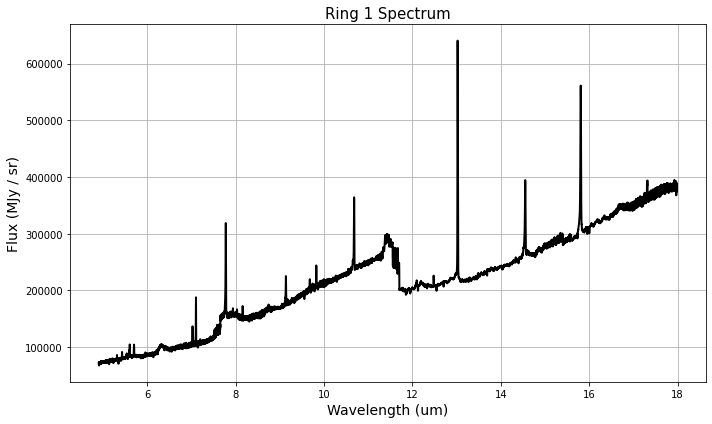

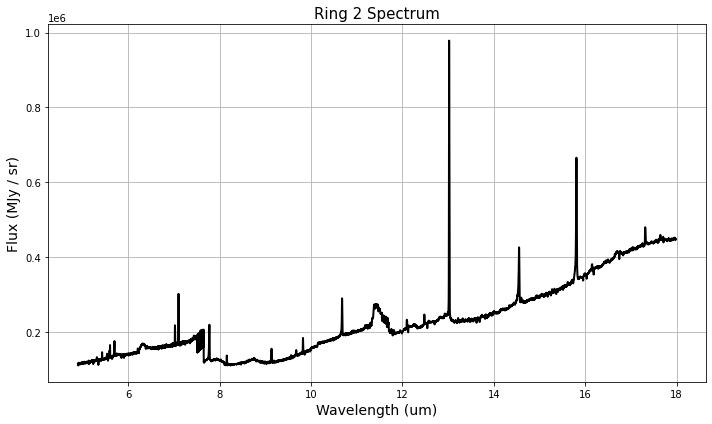

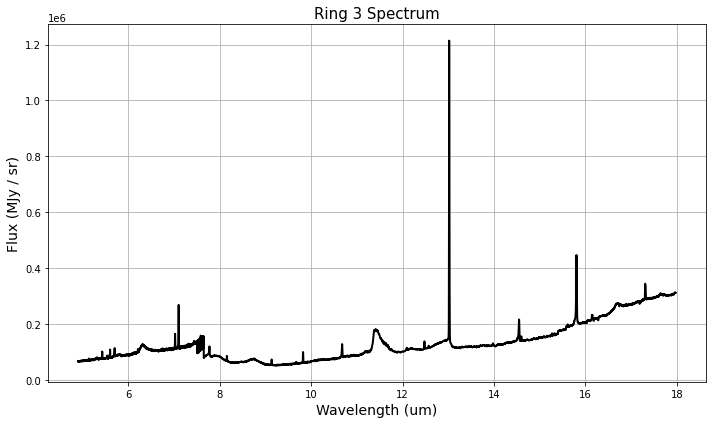

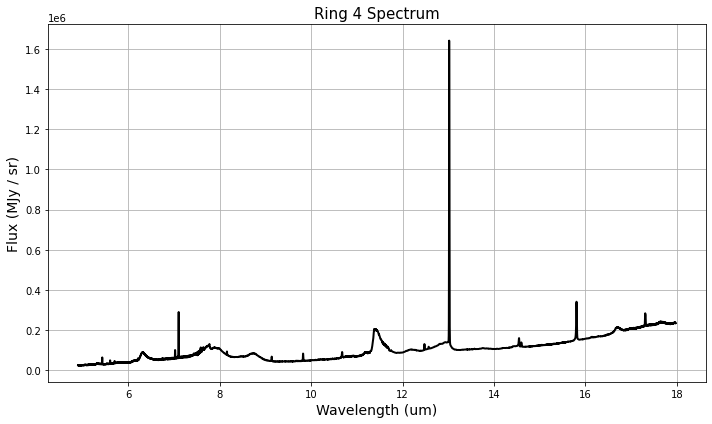

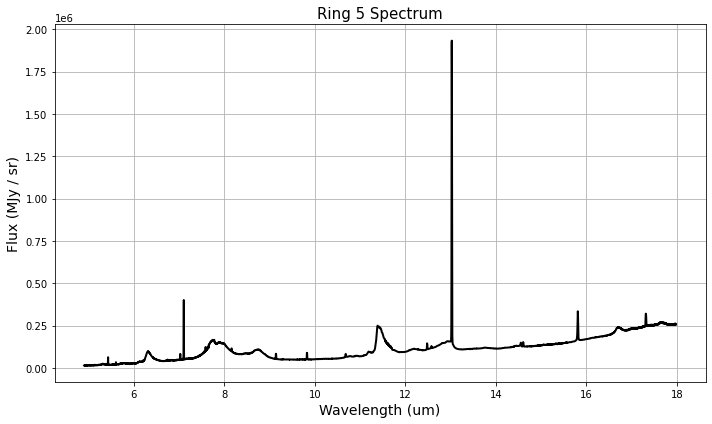

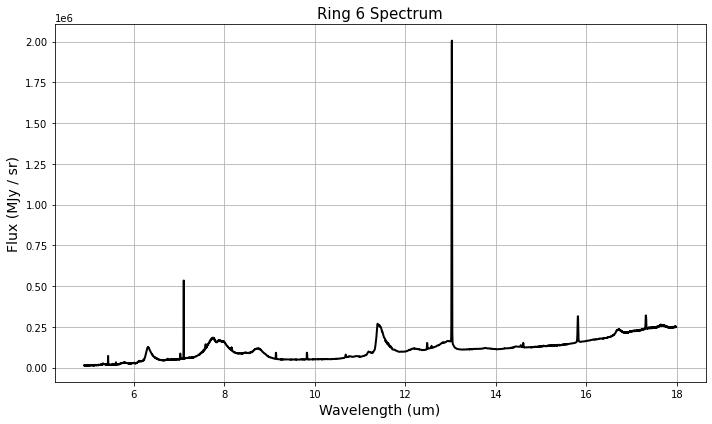

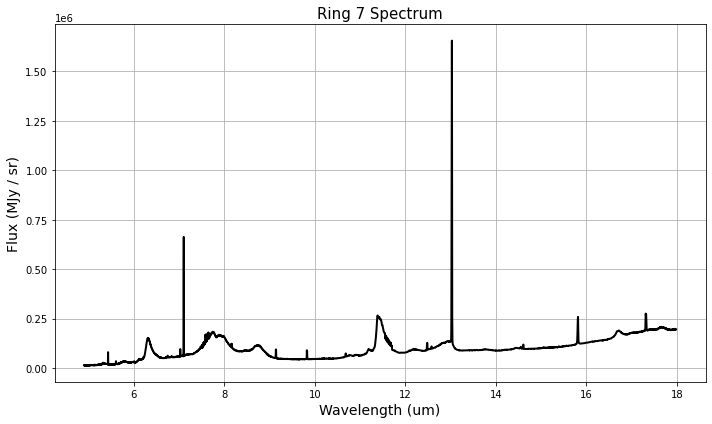

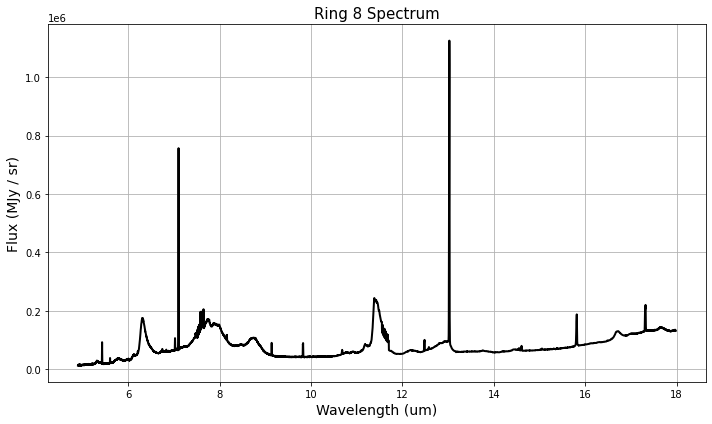

In [10]:
repo_dir = Path().resolve().parent
hydrocarbons_dir = repo_dir / "3_Hydrocarbons"

for i in range(1, 9):
    fits_file = hydrocarbons_dir / f"Ring{i}_1dspec.fits"
    if not fits_file.exists():
        print(f"[WARN] File not found: {fits_file.name}")
        continue
    table = Table.read(fits_file, hdu=1)
    wavelength = table['wavelength']
    flux = table['flux']
    plt.figure(figsize=(10, 6))
    plt.plot(wavelength, flux, color='black', lw=2)
    plt.xlabel(f"Wavelength ({wavelength.unit})", fontsize=14)
    plt.ylabel(f"Flux ({flux.unit})", fontsize=14)
    plt.title(f"Ring {i} Spectrum", fontsize=15)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

[Ring 1] Scaling region λ > 11.9 by 0.9866 to match left side.


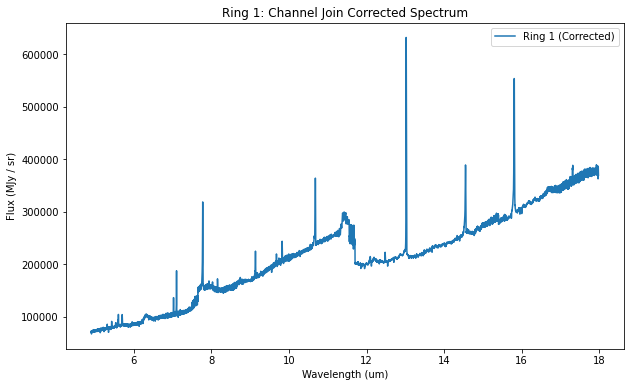

[Ring 2] Scaling region λ > 7.7 by 1.2254 to match left side.


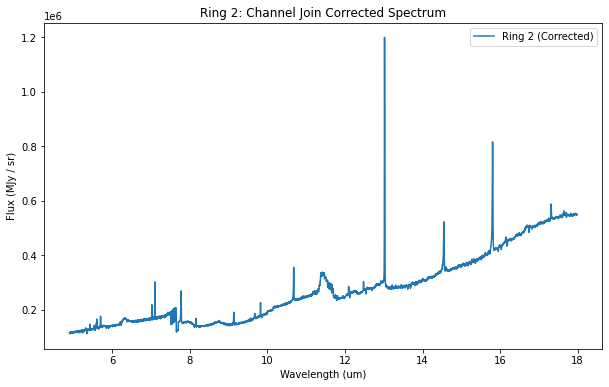

[Ring 3] Scaling region λ > 7.7 by 1.2335 to match left side.


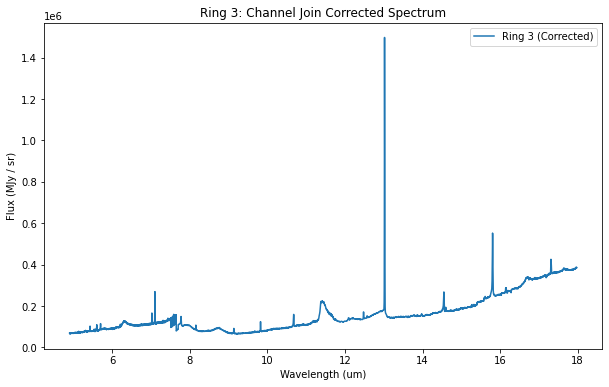

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, Column

repo_dir = Path().resolve().parent
hydrocarbons_dir = repo_dir / "3_Hydrocarbons"

# Map: ring number to join wavelength (in μm)
join_dict = {1: 11.9, 2: 7.7, 3: 7.7}

window = 0.1  # μm for overlap region

for i in range(1, 4):
    fits_file = hydrocarbons_dir / f"Ring{i}_1dspec.fits"
    table = Table.read(fits_file, hdu=1)
    wavelength = table['wavelength']
    flux = table['flux']

    # Use correct boundary for this ring
    boundary = join_dict.get(i, None)
    if boundary is None:
        print(f"[SKIP] Ring {i}: No boundary defined.")
        continue

    left_mask = (wavelength > boundary - window) & (wavelength <= boundary)
    right_mask = (wavelength > boundary) & (wavelength < boundary + window)

    if left_mask.sum() > 0 and right_mask.sum() > 0:
        left_median = np.median(flux[left_mask])
        right_median = np.median(flux[right_mask])
        scale_factor = left_median / right_median
        print(f"[Ring {i}] Scaling region λ > {boundary} by {scale_factor:.4f} to match left side.")
        # Apply the correction
        flux[wavelength > boundary] = flux[wavelength > boundary] * scale_factor
    else:
        print(f"[Ring {i}] Not enough points at join λ={boundary} for scaling.")

    # Plot before/after (if you want)
    plt.figure(figsize=(10,6))
    plt.plot(wavelength, flux, label=f"Ring {i} (Corrected)")
    plt.xlabel(f"Wavelength ({wavelength.unit})")
    plt.ylabel(f"Flux ({flux.unit})")
    plt.title(f"Ring {i}: Channel Join Corrected Spectrum")
    plt.legend()
    plt.show()

    # Optionally, save the corrected table:
    # table['flux'] = Column(flux, unit=flux.unit)  # overwrite with corrected
    # table.write(hydrocarbons_dir / f"Ring{i}_1dspec_corrected.fits", format='fits', overwrite=True)
